In [1]:
import pickle
from pathlib import Path

import getdist as gd
import getdist.plots as gdplots
import matplotlib.pyplot as plt
import numpy as np
from bulkic.config import load_config
from bulkic.data import TRUE_IC
from sampling.priors import CompoundPrior

In [2]:
cfg = load_config(Path() / "config.yaml")
prior = CompoundPrior.from_dict(cfg.priors.model_dump())
prior_samples = prior.sample(500_000, np.random.default_rng(1234))

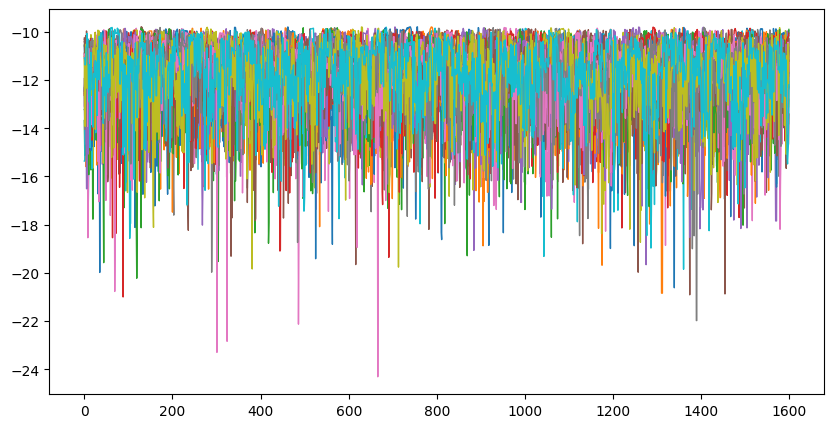

In [3]:
LN_PROB_PATH = Path().parent / "lnprob.pkl"
ln_prob = pickle.load(open(LN_PROB_PATH, "rb"))

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(ln_prob.reshape(-1, 20), lw=1)
plt.show()

In [4]:
SAMPLES_PATH = Path() / "samples.pkl"
samples = pickle.load(open(SAMPLES_PATH, "rb"))
samples.shape

(32000, 5)

Removed no burn in
Removed no burn in


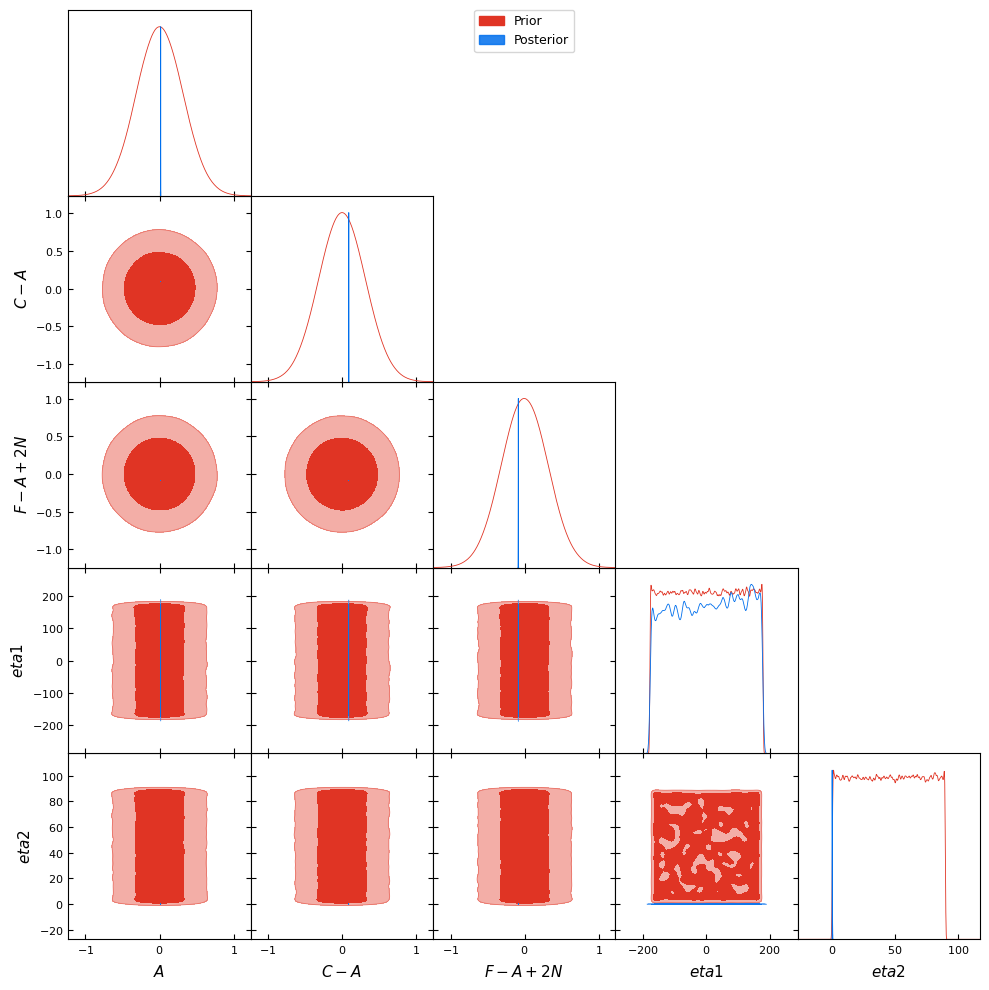

In [43]:
names = ["A", "C-A", "F-A+2N", "eta1", "eta2"]
posterior_samples_gd = gd.MCSamples(samples=samples, names=names, labels=names)
prior_samples_gd = gd.MCSamples(samples=prior_samples, names=names, labels=names)
g = gdplots.getSubplotPlotter()
g.triangle_plot(
    [prior_samples_gd, posterior_samples_gd],
    legend_labels=["Prior", "Posterior"],
    filled=True,
)

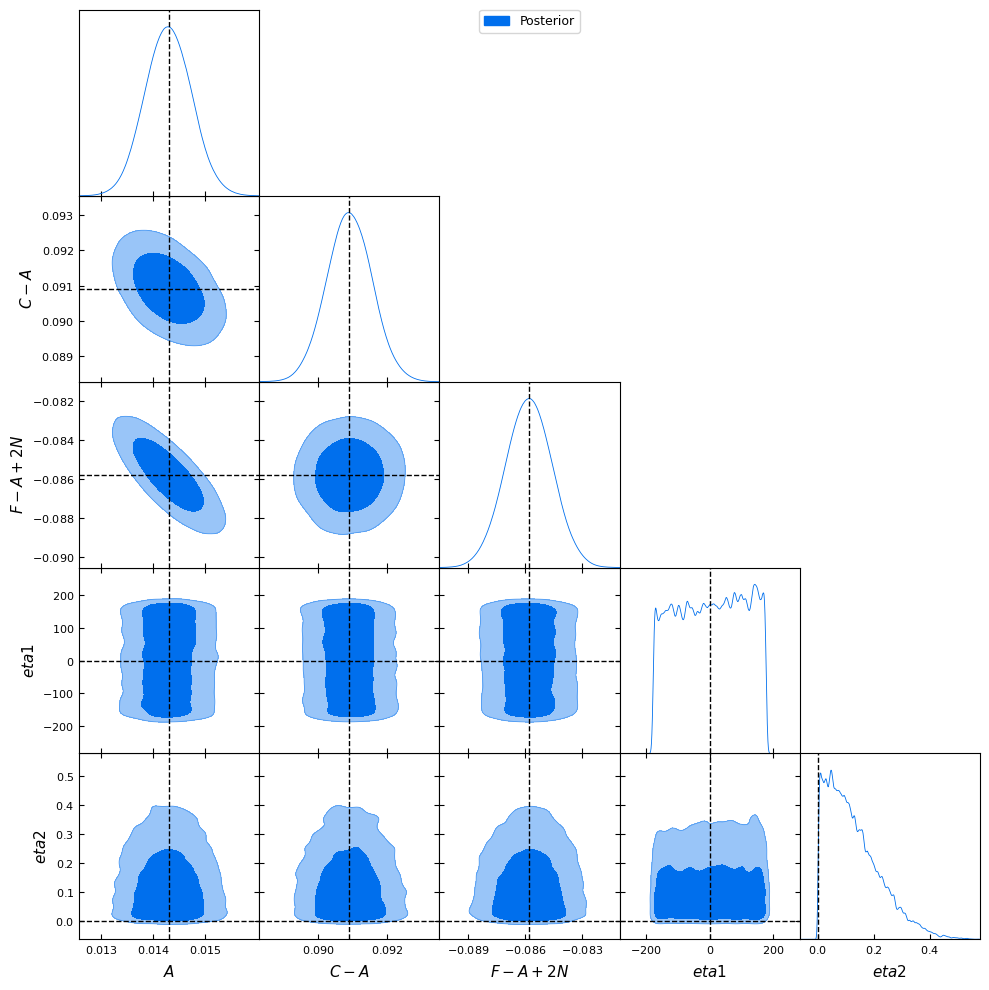

In [6]:
g.triangle_plot(
    [posterior_samples_gd],
    legend_labels=["Posterior"],
    filled=True,
    markers=TRUE_IC.as_array(),
    marker_args={"color": "k", "lw": 1},
)

/var/folders/09/3w8zj_452w14j_351ybq0g240000gp/T/ipykernel_83643/2781987296.py:116: MatplotlibDeprecationWarning: Passing label as a length 5 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  ax_row[0].plot(xs, min_max_norm(tts), label=labels)


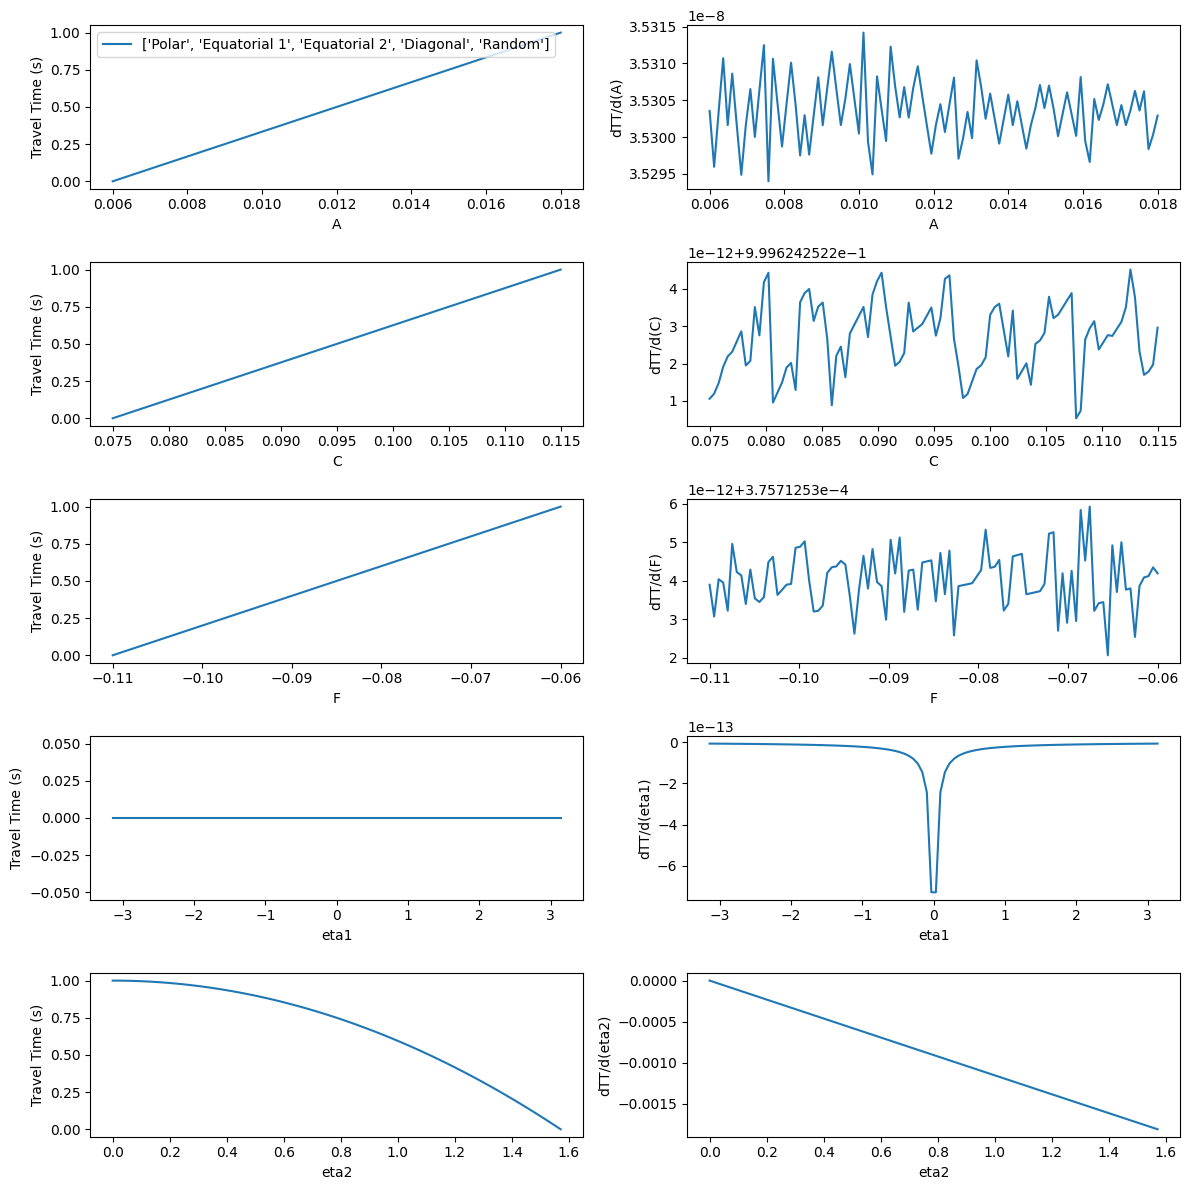

In [53]:
from tti.forward import TravelTimeCalculator


def finite_difference(f, x, index=0, rel_step=1e-4, abs_step=1e-7):
    h = max(abs(x[index]) * rel_step, abs_step)
    xp2h = x.copy()
    xp2h[index] += 2 * h
    xph = x.copy()
    xph[index] += h
    xmh = x.copy()
    xmh[index] -= h
    xm2h = x.copy()
    xm2h[index] -= 2 * h
    return (-f(xp2h) + 8 * f(xph) - 8 * f(xmh) + f(xm2h)) / (12 * h)


def min_max_norm(arr):
    arr_min = np.min(arr, axis=0)
    arr_max = np.max(arr, axis=0)
    denom = np.where(arr_max > arr_min, arr_max - arr_min, 1.0)
    return (arr - arr_min) / denom


def max_abs_norm(arr):
    denom = np.maximum(np.max(np.abs(arr), axis=0), 1.0)
    return arr / denom


r_ic = 1221.5  # km
rng = np.random.default_rng(42)

polar_path = (
    np.array([0.0, -90.0, r_ic]),
    np.array([0.0, 90.0, r_ic]),
)  # South to North

equatorial_path1 = (
    np.array([-90.0, 0.0, r_ic]),
    np.array([90.0, 0.0, r_ic]),
)  # West to East

equatorial_path2 = (
    np.array([0.0, 0.0, r_ic]),
    np.array([180.0, 0.0, r_ic]),
)  # Prime meridian

diagonal_path = (
    np.array([-90.0, -90.0, r_ic]),
    np.array([90.0, 90.0, r_ic]),
)  # SW to NE

random_path = (
    np.array([rng.uniform(-180, 180), rng.uniform(0, 90), r_ic]),
    np.array([rng.uniform(-180, 180), rng.uniform(0, 90), r_ic]),
)  # Random
labels = ["Polar", "Equatorial 1", "Equatorial 2", "Diagonal", "Random"]


ic_ins = np.array(
    [
        polar_path[0],
        # equatorial_path1[0],
        # equatorial_path2[0],
        # diagonal_path[0],
        # random_path[0],
    ]
)


ic_outs = np.array(
    [
        polar_path[1],
        # equatorial_path1[1],
        # equatorial_path2[1],
        # diagonal_path[1],
        # random_path[1],
    ]
)


tt_calc = TravelTimeCalculator(ic_in=ic_ins, ic_out=ic_outs, nested=False, shear=False)


def calc_dtt(index, xs):
    m0 = np.array([0.0143, 0.0909, -0.858, np.pi / 4, np.pi / 4])
    tts, dtt_dxs = [], []
    for x in xs:
        m = m0.copy()
        m[index] = x
        tt = tt_calc(m)
        tts.append(tt)
        dtt = finite_difference(tt_calc, m, index=index)
        dtt_dxs.append(dtt)
    return np.array(tts), np.array(dtt_dxs)


n = 100


configs = [
    ("A", 0, np.linspace(6e-3, 1.8e-2, n)),
    ("C", 1, np.linspace(7.5e-2, 11.5e-2, n)),
    ("F", 2, np.linspace(-11e-2, -6e-2, n)),
    ("eta1", 3, np.radians(np.linspace(-180, 180, n))),
    ("eta2", 4, np.radians(np.linspace(0, 90, n))),
]


fig, axes = plt.subplots(5, 2, figsize=(12, 12), tight_layout=True)


for ax_row, (name, index, xs) in zip(axes, configs):
    tts, dtt_dxs = calc_dtt(index, xs)

    ax_row[0].plot(xs, min_max_norm(tts), label=labels)
    ax_row[0].set_xlabel(name)
    ax_row[0].set_ylabel("Travel Time (s)")

    ax_row[1].plot(xs, dtt_dxs)
    ax_row[1].set_xlabel(name)
    ax_row[1].set_ylabel(f"dTT/d({name})")

axes[0, 0].legend()